<a href="https://colab.research.google.com/github/Chetan2003/FPGAHackathon/blob/main/rttDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
STEP 1: Loading data
  Loaded drone data/rtt_log_run1.csv: 2990 rows
  Loaded drone data/rtt_log_run2.csv: 2990 rows
  Loaded drone data/rtt_log_run3.csv: 2990 rows
  Loaded drone data/rtt_log_run4.csv: 2990 rows
  Loaded drone data/rtt_log_run5.csv: 2990 rows
  Loaded drone data/rtt_log_run6.csv: 2990 rows

Total rows: 17940

Feature stats:
           rtt_ms    rssi_dbm  drone_distance_m
count  17940.0000  17940.0000        17940.0000
mean       1.8479    -65.4520           91.2003
std        2.9187      2.9426           29.5212
min        0.1993    -70.2562           50.0000
25%        0.2047    -67.9187           62.6824
50%        0.6414    -65.8490           90.3091
75%        2.6024    -62.6773          114.6085
max       88.8841    -60.7138          149.9997

STEP 2: Normalizing features
Feature scaler ranges:
  rtt_ms: [0.1993, 88.8841]
  rssi_dbm: [-70.2562, -60.7138]
  drone_distance_m: [50.0000, 149.9997]
Scaler params saved → scaler_params.npy

STEP 3: Bu

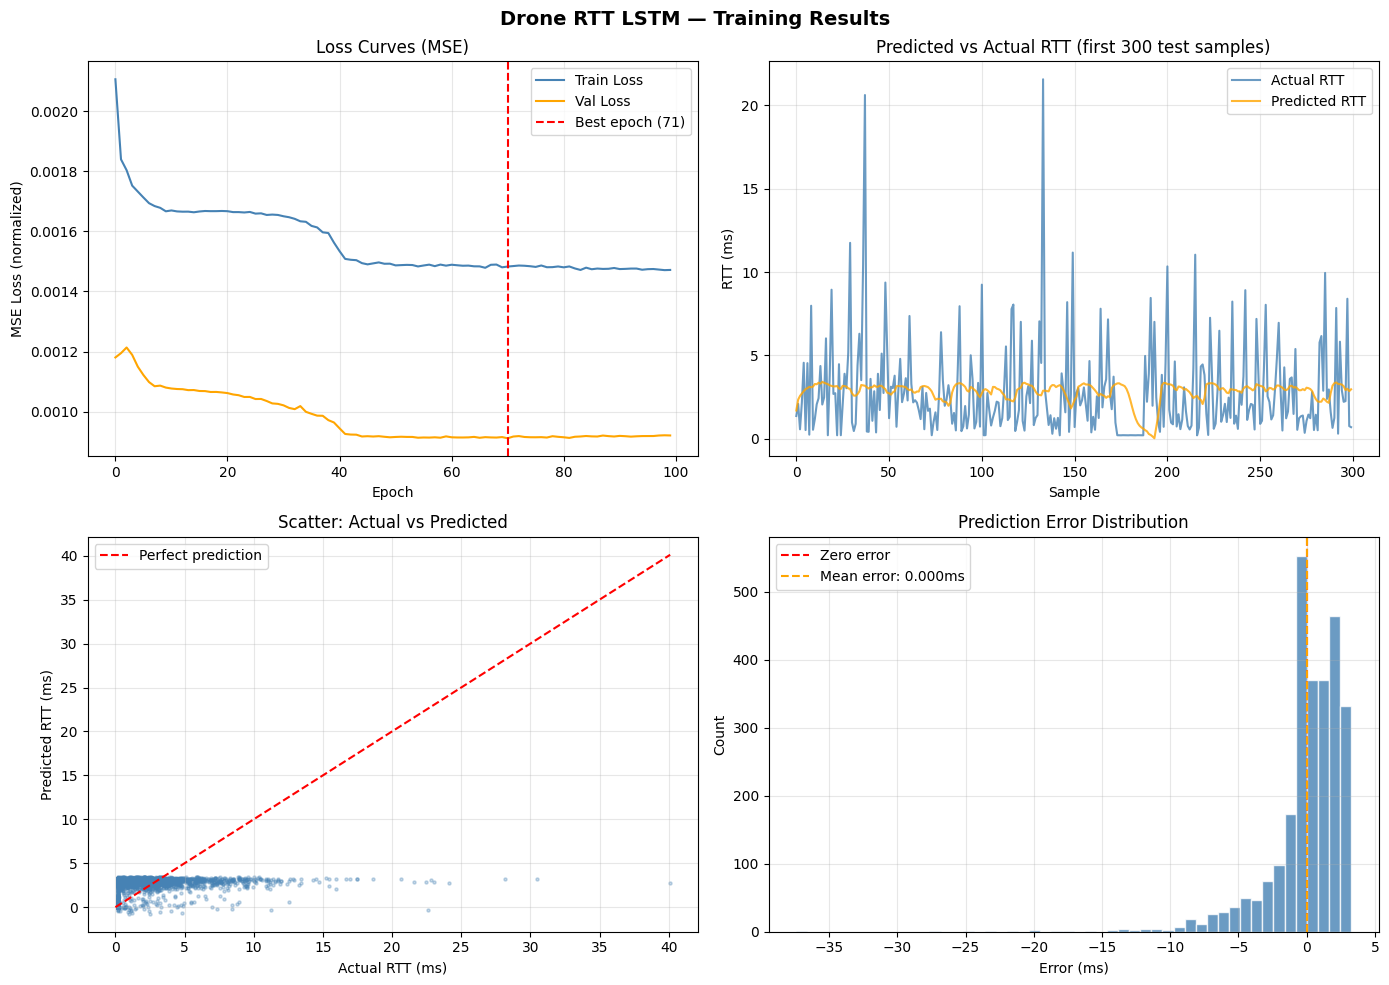

In [ ]:
# =============================================================
# Drone RTT Prediction — PyTorch LSTM Training Script
# =============================================================
# Input  : 6 CSV files from NS3 simulation
# Output : trained model weights (rtt_lstm.pt)
#          scaler parameters   (scaler_params.npy)
#          training plots      (training_plot.png)
#          weight summary      (weights_summary.txt)
#
# Usage:
#   pip install torch pandas scikit-learn matplotlib numpy
#   python lstm_train.py
# =============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ─────────────────────────────────────────────
# CONFIG — tweak these freely
# ─────────────────────────────────────────────
CSV_FILES = [
    "drone data/rtt_log_run1.csv",
    "drone data/rtt_log_run2.csv",
    "drone data/rtt_log_run3.csv",
    "drone data/rtt_log_run4.csv",
    "drone data/rtt_log_run5.csv",
    "drone data/rtt_log_run6.csv",
]

# Features fed into the LSTM at each timestep
# packet_loss_rate dropped — always 0 in our data
FEATURES = ["rtt_ms", "rssi_dbm", "drone_distance_m"]

# Target: predict RTT N steps ahead
PREDICT_HORIZON = 5        # 5 steps × 100ms = 500ms ahead

# Sliding window: how many past timesteps the LSTM sees
WINDOW_SIZE = 20           # 20 steps = 2 seconds of history

# Model architecture
HIDDEN_SIZE_1 = 32         # First LSTM layer hidden units
HIDDEN_SIZE_2 = 16         # Second LSTM layer hidden units

# Training
EPOCHS       = 100
BATCH_SIZE   = 64
LEARNING_RATE = 0.001
TRAIN_RATIO  = 0.70
VAL_RATIO    = 0.15
# TEST_RATIO  = 0.15 (remainder)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# =============================================================
# STEP 1 — Load and combine all CSVs
# =============================================================
def load_data(csv_files):
    frames = []
    for f in csv_files:
        if not os.path.exists(f):
            print(f"  WARNING: {f} not found, skipping.")
            continue
        df = pd.read_csv(f)
        df["run"] = f  # track which run each row came from
        frames.append(df)
        print(f"  Loaded {f}: {len(df)} rows")

    combined = pd.concat(frames, ignore_index=True)
    print(f"\nTotal rows: {len(combined)}")
    return combined


print("=" * 55)
print("STEP 1: Loading data")
print("=" * 55)
df = load_data(CSV_FILES)

# Quick sanity check
print(f"\nFeature stats:")
print(df[FEATURES].describe().round(4))


# =============================================================
# STEP 2 — Normalize features
# Feature-wise MinMax scaling to [0, 1]
# Fit scaler ONLY on training portion to avoid data leakage
# =============================================================
print("\n" + "=" * 55)
print("STEP 2: Normalizing features")
print("=" * 55)

feature_data = df[FEATURES].values.astype(np.float32)
target_data  = df["rtt_ms"].values.astype(np.float32)

# Chronological split indices
n = len(feature_data)
train_end = int(n * TRAIN_RATIO)
val_end   = int(n * (TRAIN_RATIO + VAL_RATIO))

# Fit scaler only on training data
feature_scaler = MinMaxScaler()
feature_scaler.fit(feature_data[:train_end])
feature_scaled = feature_scaler.transform(feature_data)

# Scale target (RTT) separately — need inverse transform for evaluation
target_scaler = MinMaxScaler()
target_scaler.fit(target_data[:train_end].reshape(-1, 1))
target_scaled = target_scaler.transform(target_data.reshape(-1, 1)).flatten()

print(f"Feature scaler ranges:")
for i, fname in enumerate(FEATURES):
    print(f"  {fname}: [{feature_scaler.data_min_[i]:.4f}, {feature_scaler.data_max_[i]:.4f}]")

# Save scaler params for inference (needed for FPGA pre-processing)
np.save("scaler_params.npy", {
    "feature_min":  feature_scaler.data_min_,
    "feature_max":  feature_scaler.data_max_,
    "target_min":   target_scaler.data_min_,
    "target_max":   target_scaler.data_max_,
    "features":     FEATURES,
    "window_size":  WINDOW_SIZE,
    "horizon":      PREDICT_HORIZON,
})
print("Scaler params saved → scaler_params.npy")


# =============================================================
# STEP 3 — Build sliding window sequences
#
# For each timestep t, create:
#   X[t] = feature_scaled[t - WINDOW_SIZE : t]     shape: (20, 3)
#   y[t] = target_scaled[t + PREDICT_HORIZON]       shape: (1,)
#
# This teaches the model: "given the last 2 seconds of data,
# predict RTT 500ms into the future"
# =============================================================
print("\n" + "=" * 55)
print("STEP 3: Building sliding window sequences")
print("=" * 55)

def make_sequences(features, targets, window, horizon):
    X, y = [], []
    # Need window past steps + horizon future steps
    for i in range(window, len(features) - horizon):
        X.append(features[i - window : i])     # (window, n_features)
        y.append(targets[i + horizon])          # scalar
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = make_sequences(feature_scaled, target_scaled, WINDOW_SIZE, PREDICT_HORIZON)
print(f"Sequence shape X: {X.shape}  →  (samples, window, features)")
print(f"Sequence shape y: {y.shape}  →  (samples,)")

# Chronological split — never shuffle time series!
n_seq      = len(X)
train_end_seq = int(n_seq * TRAIN_RATIO)
val_end_seq   = int(n_seq * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X[:train_end_seq],            y[:train_end_seq]
X_val,   y_val   = X[train_end_seq:val_end_seq], y[train_end_seq:val_end_seq]
X_test,  y_test  = X[val_end_seq:],              y[val_end_seq:]

print(f"\nSplit sizes:")
print(f"  Train : {len(X_train)} sequences ({TRAIN_RATIO*100:.0f}%)")
print(f"  Val   : {len(X_val)}   sequences ({VAL_RATIO*100:.0f}%)")
print(f"  Test  : {len(X_test)}  sequences ({(1-TRAIN_RATIO-VAL_RATIO)*100:.0f}%)")


# =============================================================
# STEP 4 — PyTorch Dataset and DataLoader
# =============================================================
class RTTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # (N,1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader = DataLoader(RTTDataset(X_train, y_train),
                          batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(RTTDataset(X_val,   y_val),
                          batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(RTTDataset(X_test,  y_test),
                          batch_size=BATCH_SIZE, shuffle=False)


# =============================================================
# STEP 5 — LSTM Model Definition
#
# Architecture:
#   LSTM(3→32, return_seq=True)
#   LSTM(32→16)
#   Linear(16→1)
#
# Small by design — must be implementable in Verilog RTL
# Hidden sizes 32 and 16 keep weight matrices manageable
# =============================================================
class DroneRTTLSTM(nn.Module):
    def __init__(self, input_size, hidden1, hidden2):
        super(DroneRTTLSTM, self).__init__()

        self.lstm1 = nn.LSTM(
            input_size  = input_size,
            hidden_size = hidden1,
            num_layers  = 1,
            batch_first = True
        )

        self.dropout1 = nn.Dropout(p=0.2)  # drops 20% of neurons → prevents overfitting

        self.lstm2 = nn.LSTM(
            input_size  = hidden1,
            hidden_size = hidden2,
            num_layers  = 1,
            batch_first = True
        )

        self.dropout2 = nn.Dropout(p=0.2)

        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        out1, _ = self.lstm1(x)
        out1 = self.dropout1(out1)

        out2, _ = self.lstm2(out1)
        last_hidden = out2[:, -1, :]
        last_hidden = self.dropout2(last_hidden)

        prediction = self.fc(last_hidden)
        return prediction


model = DroneRTTLSTM(
    input_size = len(FEATURES),
    hidden1    = HIDDEN_SIZE_1,
    hidden2    = HIDDEN_SIZE_2
).to(DEVICE)

print("\n" + "=" * 55)
print("STEP 4: Model architecture")
print("=" * 55)
print(model)

# Count total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")
print(f"  (Small enough for Verilog RTL implementation)")


# =============================================================
# STEP 6 — Training Loop
# =============================================================
# Custom weighted MSE — penalizes underprediction of high RTT spikes
# 5x penalty on samples where normalized RTT > 0.3 (jammed region)
class WeightedMSELoss(nn.Module):
    def __init__(self, threshold=0.3, high_weight=5.0):
        super().__init__()
        self.threshold   = threshold
        self.high_weight = high_weight

    def forward(self, pred, target):
        weights = torch.where(
            target > self.threshold,
            torch.tensor(self.high_weight, device=pred.device),
            torch.tensor(1.0,              device=pred.device)
        )
        return (weights * (pred - target) ** 2).mean()

criterion = WeightedMSELoss(threshold=0.3, high_weight=3.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler — reduce LR when val loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

train_losses = []
val_losses   = []
best_val_loss = float('inf')
best_epoch    = 0

print("\n" + "=" * 55)
print("STEP 5: Training")
print("=" * 55)

for epoch in range(1, EPOCHS + 1):
    # ── Training ──
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()

        # Gradient clipping — prevents exploding gradients in LSTM
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * len(X_batch)

    train_loss /= len(train_loader.dataset)

    # ── Validation ──
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * len(X_batch)

    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step scheduler
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch    = epoch
        torch.save(model.state_dict(), "rtt_lstm.pt")

    # Print every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch [{epoch:3d}/{EPOCHS}]  "
              f"Train Loss: {train_loss:.6f}  "
              f"Val Loss: {val_loss:.6f}"
              + (" ← best" if epoch == best_epoch else ""))

print(f"\nBest model saved at epoch {best_epoch} "
      f"(val loss = {best_val_loss:.6f}) → rtt_lstm.pt")


# =============================================================
# STEP 7 — Test Evaluation
# =============================================================
print("\n" + "=" * 55)
print("STEP 6: Test evaluation")
print("=" * 55)

# Load best model weights
model.load_state_dict(torch.load("rtt_lstm.pt", map_location=DEVICE))
model.eval()

all_preds = []
all_true  = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        preds = model(X_batch).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_true.extend(y_batch.cpu().numpy().flatten())

all_preds = np.array(all_preds)
all_true  = np.array(all_true)

# Inverse transform back to original ms scale
preds_ms = target_scaler.inverse_transform(
    all_preds.reshape(-1, 1)).flatten()
true_ms  = target_scaler.inverse_transform(
    all_true.reshape(-1, 1)).flatten()

mae  = mean_absolute_error(true_ms, preds_ms)
rmse = np.sqrt(mean_squared_error(true_ms, preds_ms))
mape = np.mean(np.abs((true_ms - preds_ms) / (true_ms + 1e-8))) * 100

print(f"MAE  : {mae:.4f} ms")
print(f"RMSE : {rmse:.4f} ms")
print(f"MAPE : {mape:.2f}%")
print(f"\nPrediction samples (actual → predicted):")
for i in range(0, min(10, len(true_ms)), 1):
    print(f"  actual={true_ms[i]:.3f}ms  predicted={preds_ms[i]:.3f}ms")


# =============================================================
# STEP 8 — Plots
# =============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Drone RTT LSTM — Training Results", fontsize=14, fontweight='bold')

# Plot 1: Training and validation loss curves
axes[0,0].plot(train_losses, label="Train Loss", color="steelblue")
axes[0,0].plot(val_losses,   label="Val Loss",   color="orange")
axes[0,0].axvline(best_epoch - 1, color='red', linestyle='--',
                   label=f"Best epoch ({best_epoch})")
axes[0,0].set_title("Loss Curves (MSE)")
axes[0,0].set_xlabel("Epoch")
axes[0,0].set_ylabel("MSE Loss (normalized)")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Predicted vs actual RTT on test set (first 300 points)
n_show = min(300, len(true_ms))
axes[0,1].plot(true_ms[:n_show],  label="Actual RTT",    color="steelblue", alpha=0.8)
axes[0,1].plot(preds_ms[:n_show], label="Predicted RTT", color="orange",    alpha=0.8)
axes[0,1].set_title(f"Predicted vs Actual RTT (first {n_show} test samples)")
axes[0,1].set_xlabel("Sample")
axes[0,1].set_ylabel("RTT (ms)")
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Scatter plot — perfect prediction = diagonal line
axes[1,0].scatter(true_ms, preds_ms, alpha=0.3, s=5, color="steelblue")
max_val = max(true_ms.max(), preds_ms.max())
axes[1,0].plot([0, max_val], [0, max_val], 'r--', label="Perfect prediction")
axes[1,0].set_title("Scatter: Actual vs Predicted")
axes[1,0].set_xlabel("Actual RTT (ms)")
axes[1,0].set_ylabel("Predicted RTT (ms)")
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Prediction error distribution
errors = preds_ms - true_ms
axes[1,1].hist(errors, bins=50, color="steelblue", edgecolor="white", alpha=0.8)
axes[1,1].axvline(0, color='red', linestyle='--', label="Zero error")
axes[1,1].axvline(errors.mean(), color='orange', linestyle='--',
                   label=f"Mean error: {errors.mean():.3f}ms")
axes[1,1].set_title("Prediction Error Distribution")
axes[1,1].set_xlabel("Error (ms)")
axes[1,1].set_ylabel("Count")
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_plot.png", dpi=150, bbox_inches='tight')
print("\nPlots saved → training_plot.png")


# =============================================================
# STEP 9 — Extract and save weights for Verilog implementation
#
# This dumps all LSTM weight matrices and biases in a format
# you can directly reference when writing the RTL.
# For FPGA: these floats will be quantized to fixed-point (Q8.8)
# =============================================================
print("\n" + "=" * 55)
print("STEP 7: Extracting weights for Verilog")
print("=" * 55)

weights_summary = []
weights_summary.append("=" * 60)
weights_summary.append("LSTM WEIGHT SUMMARY FOR VERILOG RTL IMPLEMENTATION")
weights_summary.append("=" * 60)
weights_summary.append(f"Input size  : {len(FEATURES)}")
weights_summary.append(f"Hidden1     : {HIDDEN_SIZE_1}")
weights_summary.append(f"Hidden2     : {HIDDEN_SIZE_2}")
weights_summary.append(f"Window size : {WINDOW_SIZE}")
weights_summary.append(f"Horizon     : {PREDICT_HORIZON} steps ({PREDICT_HORIZON*100}ms)")
weights_summary.append("")

state = model.state_dict()
for name, param in state.items():
    arr = param.cpu().numpy()
    weights_summary.append(f"Layer: {name}")
    weights_summary.append(f"  Shape : {arr.shape}")
    weights_summary.append(f"  Min   : {arr.min():.6f}")
    weights_summary.append(f"  Max   : {arr.max():.6f}")
    weights_summary.append(f"  Mean  : {arr.mean():.6f}")
    weights_summary.append(f"  Std   : {arr.std():.6f}")
    weights_summary.append("")

# LSTM1 gate breakdown — important for Verilog
# PyTorch stores LSTM gates in order: [input, forget, cell, output]
# Each gate weight matrix is hidden_size rows
w_ih1 = state['lstm1.weight_ih_l0'].cpu().numpy()  # (4*H1, input_size)
w_hh1 = state['lstm1.weight_hh_l0'].cpu().numpy()  # (4*H1, H1)
H1 = HIDDEN_SIZE_1

weights_summary.append("-" * 60)
weights_summary.append("LSTM1 Gate Breakdown (for RTL — 4 gates × H1 rows each):")
weights_summary.append(f"  W_ii (input→input  gate) shape: {w_ih1[:H1].shape}")
weights_summary.append(f"  W_if (input→forget gate) shape: {w_ih1[H1:2*H1].shape}")
weights_summary.append(f"  W_ig (input→cell   gate) shape: {w_ih1[2*H1:3*H1].shape}")
weights_summary.append(f"  W_io (input→output gate) shape: {w_ih1[3*H1:].shape}")
weights_summary.append(f"  W_hi (hidden→input  gate) shape: {w_hh1[:H1].shape}")
weights_summary.append(f"  W_hf (hidden→forget gate) shape: {w_hh1[H1:2*H1].shape}")
weights_summary.append(f"  W_hg (hidden→cell   gate) shape: {w_hh1[2*H1:3*H1].shape}")
weights_summary.append(f"  W_ho (hidden→output gate) shape: {w_hh1[3*H1:].shape}")
weights_summary.append("")
weights_summary.append("NOTE: For fixed-point quantization (Q8.8 format):")
weights_summary.append("  multiply float weights by 256, round to int16")
weights_summary.append("  sigmoid(x) ≈ LUT with 256 entries")
weights_summary.append("  tanh(x)    ≈ LUT with 256 entries")

summary_text = "\n".join(weights_summary)
with open("weights_summary.txt", "w") as f:
    f.write(summary_text)

print(summary_text)
print("\nWeights summary saved → weights_summary.txt")

# Also save raw weights as numpy arrays for quantization script
np.save("lstm_weights.npy", {k: v.cpu().numpy() for k, v in state.items()})
print("Raw weights saved → lstm_weights.npy")

print("\n" + "=" * 55)
print("DONE. Output files:")
print("  rtt_lstm.pt          — trained model weights")
print("  scaler_params.npy    — normalization params")
print("  lstm_weights.npy     — raw weight arrays")
print("  weights_summary.txt  — weight shapes for Verilog")
print("  training_plot.png    — loss curves + predictions")
print("=" * 55)